https://www.kaggle.com/competitions/paddy-disease-classification

# Importing Libs and Paths

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paddy-disease-classification/sample_submission.csv
/kaggle/input/paddy-disease-classification/train.csv
/kaggle/input/paddy-disease-classification/train_images/tungro/109629.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/104765.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/109706.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/100098.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102734.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/106433.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/108930.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102019.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102416.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/101046.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/108310.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/10402

# Importing libraries

In [2]:
#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
#Working with images
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# EDA

In [3]:
train = pd.read_csv("/kaggle/input/paddy-disease-classification/train.csv")


In [4]:
train.columns

Index(['image_id', 'label', 'variety', 'age'], dtype='object')

In [5]:
train.describe()

,age
count,10407.000000
mean,64.043624
std,8.958830
min,45.000000
25%,60.000000
50%,67.000000
75%,70.000000
max,82.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  10407 non-null  object
 1   label     10407 non-null  object
 2   variety   10407 non-null  object
 3   age       10407 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 325.3+ KB


In [7]:
px.histogram(train,x="age", histnorm='probability density',title="Age distribution in days")

In [8]:
train.variety.unique()

array(['ADT45', 'IR20', 'KarnatakaPonni', 'Onthanel', 'Ponni', 'Surya',
       'Zonal', 'AndraPonni', 'AtchayaPonni', 'RR'], dtype=object)

In [9]:
px.histogram(train,x="variety", histnorm='probability density',title="Paddy varieties in data")

In [10]:
px.histogram(train,x="label", histnorm='probability density',title="Label Distribution")

In [11]:
train.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


# Viewing Images of each label

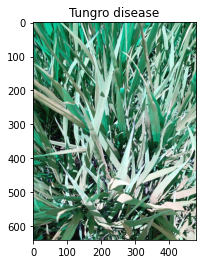

In [12]:
fig = cv2.imread("/kaggle/input/paddy-disease-classification/train_images/tungro/109629.jpg")
plt.imshow(fig, cmap='gray')
plt.title("Tungro disease")
plt.show()

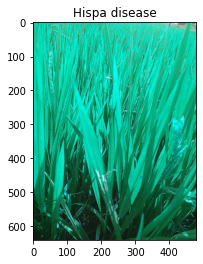

In [13]:
fig = cv2.imread("/kaggle/input/paddy-disease-classification/train_images/hispa/106590.jpg")
plt.imshow(fig, cmap='gray')
plt.title("Hispa disease")
plt.show()

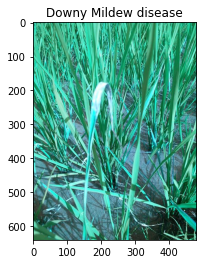

In [14]:
fig = cv2.imread("/kaggle/input/paddy-disease-classification/train_images/downy_mildew/102350.jpg")
plt.imshow(fig, cmap='gray')
plt.title("Downy Mildew disease")
plt.show()

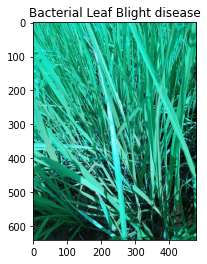

In [15]:
fig = cv2.imread("/kaggle/input/paddy-disease-classification/train_images/bacterial_leaf_blight/109372.jpg")
plt.imshow(fig, cmap='gray')
plt.title("Bacterial Leaf Blight disease")
plt.show()

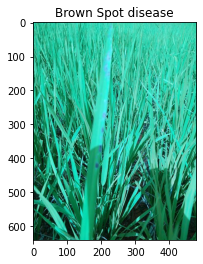

In [16]:
fig = cv2.imread("/kaggle/input/paddy-disease-classification/train_images/brown_spot/104675.jpg")
plt.imshow(fig, cmap='gray')
plt.title("Brown Spot disease")
plt.show()

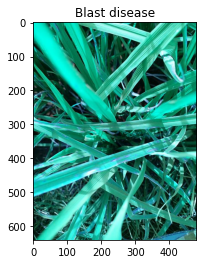

In [17]:
fig = cv2.imread("/kaggle/input/paddy-disease-classification/train_images/blast/110243.jpg")
plt.imshow(fig, cmap='gray')
plt.title("Blast disease")
plt.show()

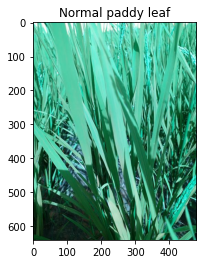

In [18]:

fig = cv2.imread("/kaggle/input/paddy-disease-classification/train_images/normal/109760.jpg")
plt.imshow(fig, cmap='gray')
plt.title("Normal paddy leaf")
plt.show()

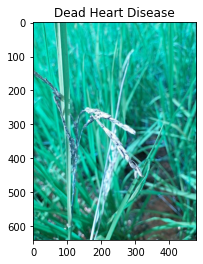

In [19]:
fig = cv2.imread("/kaggle/input/paddy-disease-classification/train_images/dead_heart/105159.jpg")
plt.imshow(fig, cmap='gray')
plt.title("Dead Heart Disease")
plt.show()

**Use a CNN to classify the images**

In [20]:
from keras.preprocessing.image import ImageDataGenerator
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1,
    rotation_range=5,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
)

In [21]:
width = 256
height = 256
batch_size = 16
path = "../input/paddy-disease-classification/train_images"
train_ds = img_datagen.flow_from_directory(
  path,
  subset="training",
  seed=123,
  target_size=(width, height),
  batch_size=batch_size,
  class_mode='categorical')

Found 9371 images belonging to 10 classes.


In [22]:
val_ds = img_datagen.flow_from_directory(
  path,
  subset="validation",
  seed=123,
  target_size=(width, height),
  batch_size=batch_size,
  class_mode='categorical')

Found 1036 images belonging to 10 classes.


In [23]:
num_classes = 10

model = Sequential([
  layers.InputLayer(input_shape=(width, height, 3)),
  layers.Conv2D(16, (3,3), padding='same', activation='relu',data_format='channels_last'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

2022-08-30 14:48:10.851033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 14:48:10.858729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 14:48:10.859945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 14:48:10.862132: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [24]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       7

In [26]:
train_ds.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [27]:
val_ds.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [29]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
586/586 [==============================] - 190s 324ms/step - loss: 7.5026 - accuracy: 0.1695 - val_loss: 7.4834 - val_accuracy: 0.1699
Epoch 2/20
586/586 [==============================] - 189s 323ms/step - loss: 7.5026 - accuracy: 0.1695 - val_loss: 7.4834 - val_accuracy: 0.1699
Epoch 3/20
586/586 [==============================] - 191s 325ms/step - loss: 7.5026 - accuracy: 0.1695 - val_loss: 7.4834 - val_accuracy: 0.1699
Epoch 4/20
586/586 [==============================] - 189s 322ms/step - loss: 7.5026 - accuracy: 0.1695 - val_loss: 7.4834 - val_accuracy: 0.1699
Epoch 5/20
586/586 [==============================] - 189s 323ms/step - loss: 7.5026 - accuracy: 0.1695 - val_loss: 7.4834 - val_accuracy: 0.1699
Epoch 6/20
586/586 [==============================] - 190s 323ms/step - loss: 7.5026 - accuracy: 0.1695 - val_loss: 7.4834 - val_accuracy: 0.1699
Epoch 7/20
586/586 [==============================] - 189s 323ms/step - loss: 7.5026 - accuracy: 0.1695 - val_loss: 7.4834 -

In [30]:

path = "../input/paddy-disease-classification/test_images"
test_ds = ImageDataGenerator(rescale=1./255).flow_from_directory(
  path,
  target_size=(width, height),
  batch_size=1,
classes=['.'],
    class_mode=None)

Found 3469 images belonging to 1 classes.


In [31]:
pred = model.predict(test_ds,verbose=1)

3469/3469 [==============================] - 36s 10ms/step


In [32]:
pred

array([[-58.652874, -27.706232, -63.99133 , ..., -67.19248 , 115.103745,
        -42.64107 ],
       [-46.60903 , -22.441572, -51.60325 , ..., -53.590935,  92.57229 ,
        -34.048782],
       [-56.256016, -26.74312 , -61.37509 , ..., -64.17695 , 109.70221 ,
        -40.684998],
       ...,
       [-56.722214, -26.83481 , -61.76204 , ..., -64.60484 , 110.798256,
        -41.281227],
       [-59.87397 , -28.468964, -65.15871 , ..., -68.07421 , 117.48784 ,
        -43.56804 ],
       [-66.77741 , -31.277723, -72.23362 , ..., -76.06725 , 130.24072 ,
        -48.58187 ]], dtype=float32)

In [33]:
predicted_class_indices=np.argmax(pred,axis=1)

In [34]:
predicted_class_indices=np.argmax(pred,axis=1)
print(set(predicted_class_indices))

inv_map = {v:k for k,v in train_ds.class_indices.items()}

predictions = [inv_map[k] for k in predicted_class_indices]

{8}


In [35]:
filenames=test_ds.filenames


In [36]:
results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

The default value of regex will change from True to False in a future version.



,image_id,label
0,200001.jpg,normal
1,200002.jpg,normal
2,200003.jpg,normal
3,200004.jpg,normal
4,200005.jpg,normal
